# Remaining Report

If you don't have the APA libraries installed on your machine, do this work on the `osf-red.aiv.alma.cl` machine, logging as `aod`. Once there you should load first the appropriate environmen variable:

```
[user@localhost ~] $ ssh -Y aod@osf-red.aiv.alma.cl
************************************************
Hi, you are logging onto OSF-RED which is a resource limited machine.
Please note:
  - keep your home directory usage  light ( less than 10Gb)
  - If possible, do your analysis on the local disks (/work_area) but move back the results of your work on the network mounted drives ( /data2/data) once done
  - **Most important**, if you are going to be a heavy user ( defined a doing Science verification data analysis, or running a large data analysis for more than 1 day), please email local scientists email list (science-only@alma.cl) as a courtesy warning.
************************************************
aod@osf-red.aiv.alma.cl's password: 


[aod@osf-red ~]$ . activateC2Test
(anaconda)[aod@osf-red ~]$ ipython


```

The first step is to load the required libraries, and then the cycle_tools

In [1]:
# The first line is only for the IPython Notebook interface
# If you are working in the ipython console replace by `%matplotlib`
%matplotlib inline

import DataBase as db
import pandas as pd
import numpy as np
import datetime as dt
import ephem

import matplotlib.pyplot as plt
#import seaborn as sns

import cx_Oracle
import os

import cycle_tools as ct
#import plotly.plotly as py

## Load APA database, process SBs and create summary Dataframe

In [2]:
datas = db.Database(verbose=False, forcenew=False)

In [3]:
datas.process_sbs(forcenew=True)
datas.do_summarize_sb()

Processing Phase II SBs ....
Warning, uid://A002/X6ac013/X1 is corrupt

Warning, uid://A002/X6ac013/X2 is corrupt

Warning, uid://A002/X788a57/X37 is corrupt

Warning, uid://A002/X788a57/X38 is corrupt
.....
Warning, uid://A001/X121/X300 is corrupt
 Done!
Processing Phase I SBs .........  Done!
42


## Create dates table for Cycle 2

1. Create the `ephem.Observer` instance with the ALMA AOS location.
2. Create a `date_df` dataframe that will contain information for each day of observations planned for the
   remaining of Cycle 2.

In [4]:
alma1 = ephem.Observer()
alma1.lat = '-23.0262015'
alma1.long = '-67.7551257'
alma1.elev = 5060

data_ar = ct.create_dates(ct.es_cycle2)

date_df = pd.DataFrame(
   np.array(data_ar),
   columns=['start', 'end', 'block', 'C34_1', 'C34_2', 'C34_3', 'C34_4', 'C34_5', 'C34_6', 'C34_7'])

lst_times = date_df.apply(lambda r: ct.day_night(r['start'], r['end'], alma1), axis=1)
date_df = pd.concat([date_df, lst_times], axis=1)
date_df['available_time'] = date_df.apply(lambda r: (r['end'] - r['start']).total_seconds() / 3600., axis=1)

The `date_df` dataframe can be exported to an excel file, if you need to review the time table created. The `ct.es_cycle2` is python list of lists. Each element list has the format:

```
['YYYY-MM-DD', 'YYYY-MM-DD', <block_name>, [n1, n2, ..]]
```

Where the first string is the starting date of a block, the second is the end date, the third is a string with the name of block, and the list can have between 1 and 7 values, that report the Configuration expected for that block. The default list (`ct.es_cycle2`) is:

```
es_cycle2 = [
    ['2015-03-31', '2015-04-06', 'block17', [1, 2]],
    ['2015-04-07', '2015-04-13', 'block18', [1, 2]],
    ['2015-04-21', '2015-04-27', 'block19', [1, 2]],
    ['2015-04-28', '2015-05-04', 'block20', [1, 2]],
    ['2015-05-12', '2015-05-18', 'block21', [3, 4]],
    ['2015-05-19', '2015-05-25', 'block22', [3, 4]],
    ['2015-06-02', '2015-06-08', 'block23', [5]],
    ['2015-06-09', '2015-06-15', 'block24', [5]],
    ['2015-06-23', '2015-06-29', 'block25', [7]],
    ['2015-06-30', '2015-07-06', 'block26', [7]],
    ['2015-07-14', '2015-07-20', 'block27', [7]],
    ['2015-07-21', '2015-07-27', 'block28', [7]],
    ['2015-08-04', '2015-08-10', 'block29', [6]],
    ['2015-08-11', '2015-08-17', 'block30', [6]],
    ['2015-08-25', '2015-08-31', 'block31', [7, 6]],
    ['2015-09-01', '2015-09-07', 'block32', [7, 6]],
    ['2015-09-15', '2015-09-21', 'block33', [7, 6]],
    ['2015-09-22', '2015-09-28', 'block34', [7, 6]]
]
```

## Retrieve PI contact data

In [5]:
conx_string = os.environ['CON_STR']
connection = cx_Oracle.connect(conx_string)
cursor = connection.cursor()
cursor.execute('SELECT ACCOUNT_ID, LASTNAME, FIRSTNAME, EMAIL FROM ALMA.ACCOUNT')
users = pd.DataFrame(
                cursor.fetchall(),
                columns=[rec[0] for rec in cursor.description])

sqlqa0 = str("SELECT SCHEDBLOCKUID as SB_UID,QA0STATUS,STARTTIME,ENDTIME,"
             "EXECBLOCKUID,EXECFRACTION "
             "FROM ALMA.AQUA_EXECBLOCK "
             "WHERE regexp_like (OBSPROJECTCODE, '^201[23].*\.[AST]')")

cursor.execute(sqlqa0)

aqua_execblock = pd.DataFrame(
    cursor.fetchall(), columns=[rec[0] for rec in cursor.description]
).set_index('SB_UID', drop=False)

## Correct time estimates for the 12m SBs, and add PI/Executive information

* Calculate better time estimate per SB (SB_ETC2_exec) using the number of targets and integration time
* Merge table with PI information and EXECUTIVE

In [6]:
d1 = pd.merge(datas.target, datas.scienceparam, on=['SB_UID', 'paramRef'])
d1 = pd.merge(d1, datas.fieldsource, on=['SB_UID', 'fieldRef'])
d1 = d1[d1.name.str.contains('Primary')]
inttimes = d1.groupby('SB_UID').intTime.sum().reset_index()
inttimes['intTime'] = inttimes.intTime / 3600.
summary = pd.merge(datas.summary_sb, inttimes, on='SB_UID')
summary['SB_ETC2_exec'] = summary.intTime * 1.0972 + 0.4712

## Add a column with the project completion ratio

In [7]:
# Add columns relevant to projects started
aqua = datas.aqua_execblock.query('QA0STATUS == "Pass"').copy()
aqua.dropna(inplace=True)
aqua['totExecTime'] = aqua.apply(lambda r: (r['ENDTIME'] - r['STARTTIME']).total_seconds() / 3600., axis=1)
aqua_times = aqua.groupby('SB_UID').sum().reset_index(drop=False)

pro_df = summary.query('array == "TWELVE-M"').groupby('CODE')[['execount', 'observed']].sum().sort()
pro_df = pd.merge(pro_df, pd.merge(summary.query('array == "TWELVE-M"')[['CODE', 'SB_UID']], aqua_times, on='SB_UID').groupby('CODE').sum(), left_index=True, right_index=True, how='outer').fillna(0)
pro_df['proj_comp_per'] = pro_df.observed / pro_df.execount

summary = pd.merge(summary, pro_df[['proj_comp_per']], left_on='CODE', right_index=True)

## `remaining_all` dataframe: first iteration

We create a `remaining_all` dataframe that includes only:

* SBs for 12m arrays
* SB State must not be FullyObserved nor Cancelled
* SB's parent project is grade A or B

In [8]:
remaining_all = summary.query(
    'array == "TWELVE-M" and phase == "II" and '
    'SB_STATE not in ["FullyObserved", "Canceled"] and '
    'PRJ_LETTER_GRADE in ["A", "B", "C"]')
remaining_all = pd.merge(remaining_all, datas.projects[['OBSPROJECT_UID', 'PI', 'EXEC']], on='OBSPROJECT_UID')
remaining_all = pd.merge(remaining_all, users, left_on='PI', right_on='ACCOUNT_ID')
remaining_all = pd.merge(remaining_all, datas.sciencegoals[['SG_ID', 'two_12m']], on='SG_ID', how='left')

## Detect Projects with SBs having  ephemeris or/and number of executions equal or higher than the number of requested executions

In [9]:
p1 = pd.merge(datas.scienceparam, datas.target, on=['paramRef', 'SB_UID'])
p2 = pd.merge(p1, datas.fieldsource, on=['fieldRef', 'SB_UID'])
p3 = p2[
    ['fieldRef', 'SB_UID', 'solarSystem', 'name', 'intendedUse', 'arraySB']
].query(
    'arraySB == "TWELVE-M" and solarSystem != "Unspecified"').SB_UID.values
remaining_ephem_codes = remaining_all.query('SB_UID in @p3').SB_UID.unique().tolist()
remaining_problem_codes = remaining_all.query('observed >= execount').SB_UID.unique().tolist()
print(remaining_all.query('SB_UID in @remaining_ephem_codes')[
        ['CODE', 'SB_UID', 'sbName', 'execount', 'observed', 'RA', 'SB_STATE']])
print(remaining_all.query('SB_UID in @remaining_problem_codes')[
        ['CODE', 'SB_UID', 'sbName', 'execount', 'observed', 'SB_STATE']])
outcod = []
outcod.extend(remaining_ephem_codes)
outcod.extend(remaining_problem_codes)
remaining = remaining_all.query('SB_UID not in @outcod')

                CODE                   SB_UID                sbName  execount  observed        RA         SB_STATE
567   2012.1.00853.S    uid://A002/X5a279f/X1  Io_345GHz_12m_C32-56         3         0         0        Suspended
568   2012.1.00853.S    uid://A002/X5a279f/X2  Io_337GHz_12m_C32-56         3         0         0        Suspended
830   2013.1.01366.T      uid://A001/X120/X70          Mars_a_07_TE         1         0         0          Waiting
831   2013.1.01366.T      uid://A001/X120/X71          Mars_b_07_TE         1         0         0          Waiting
843   2013.1.00376.S      uid://A001/X122/Xa3        Saturn_a_03_TE        10         9         0        Suspended
892   2012.1.00624.S   uid://A002/X684eb5/Xf7   Neptune_C18O_B7_12m         1         0     334.5            Ready
893   2012.1.00624.S   uid://A002/X684eb5/Xf8  Neptune_HC15N_B7_12m         1         0     334.5            Ready
904   2012.1.01123.S    uid://A002/X6802f4/Xc                 Venus         1   

## Calculate Observational parameter for each SB: LST at rise, LST at set, and ammount of time over 20 degrees.

In [10]:
alma1.horizon = ephem.degrees('20')
obs_param = remaining.apply(lambda r: ct.observable(r['RA'], r['DEC'], alma1, r['SB_UID']), axis=1)
remaining = pd.merge(remaining, obs_param, on='SB_UID').sort('CODE')

In [11]:
availability = remaining.apply(lambda r: ct.avail_calc(r['rise'], r['set'], r['C34_1'], r['C34_2'], r['C34_3'], r['C34_4'], r['C34_5'], r['C34_6'],  r['C34_7'], r['up'], r['band'], date_df), axis=1)

In [12]:
remaining = pd.concat([remaining, availability], axis=1)
remaining.RA /= 15.
remaining['SBremExec'] = remaining.execount - remaining.observed 
remaining['SBtimeNeedComp'] = remaining.SB_ETC2_exec * remaining.SBremExec

In [13]:
remaining['stale'] = remaining.apply(lambda r: 'SB Stale' if r['observed'] > 0 and (r['C34_1'] == 0 and r['C34_2'] == 0) else 'SB Ready', axis=1)
remaining['proj_started'] = remaining.apply(lambda r: 'Prj. Stale' if r['proj_comp_per'] > 0 else 'Prj. Ready', axis=1)
unlikely = remaining.query('available_hours == 0').copy()
critical = remaining.query('24 > available_hours > 0').copy()
ok = remaining.query('available_hours >= 24').copy()

unlikely['Problem'] = 'Null SBEL'
critical['Problem'] = 'Low SBEL'
ok['Problem'] = 'High SBEL'

codep2 = unlikely.SB_UID.values
codep1 = critical.SB_UID.values
codep0 = ok.SB_UID.values

remaining['Problem'] = 'High SBEL'
remaining['Problem'] = remaining.apply(lambda r: 'Null SBEL' if r['SB_UID'] in codep2 else r['Problem'], axis=1)
remaining['Problem'] = remaining.apply(lambda r: 'Low SBEL' if r['SB_UID'] in codep1 else r['Problem'], axis=1)

proj_unlikely = remaining.query('Problem == "Null SBEL"').CODE.unique()
proj_critical = remaining.query('Problem == "Low SBEL" and CODE not in @proj_unlikely').CODE.unique()
proj_ok = remaining.query('Problem == "High SBEL" and CODE not in @proj_unlikely and CODE not in @proj_critical').CODE.unique()

remaining['Prj. Problem'] = 'High PCL'
remaining['Prj. Problem'] = remaining.apply(lambda r: 'Null PCL' if r['CODE'] in proj_unlikely else r['Prj. Problem'], axis=1)
remaining['Prj. Problem'] = remaining.apply(lambda r: 'Low PCL' if r['CODE'] in proj_critical else r['Prj. Problem'], axis=1)

In [14]:
remaining['Cycle'] = remaining.apply(lambda r: 'Cycle 2' if r['isCycle2'] == True else 'Cycle 1', axis=1)

In [15]:
compact_high = remaining.query(
    'C34_3 == 0 and C34_4 == 0 and C34_5 == 0 and C34_6 == 0 and '
    'C34_7 == 0 and Problem == "Null SBEL" and band in ["ALMA_RB_08", "ALMA_RB_09"]'
).SB_UID.values

high_day = remaining.query(
    'Problem == "Null SBEL" and '
    'band in ["ALMA_RB_07", "ALMA_RB_08", "ALMA_RB_09"] and SB_UID not in @compact_high'
).SB_UID.values

remaining['Null SBEL Description'] = ''
remaining['Null SBEL Description'] = remaining.apply(
    lambda r: 'C34-1/2 High Frequency' if r['SB_UID'] in compact_high else r['Null SBEL Description'],
    axis=1)

remaining['Null SBEL Description'] = remaining.apply(
    lambda r: 'Daytime High Frequency' if r['SB_UID'] in high_day else r['Null SBEL Description'],
    axis=1)

In [16]:
remaining['Representative LST'] = remaining.apply(lambda r: round(r['RA']) if round(r['RA']) != 24 else 0,
                                                  axis=1)
remaining['SB_ETC2_total'] = remaining.SB_ETC2_exec * remaining.execount
remaining['SB_ETC2_remain'] = remaining.SB_ETC2_exec * (remaining.execount - remaining.observed)

In [17]:
remaining.query('PRJ_LETTER_GRADE != "C"').shape

(802, 74)

In [18]:
remaining.query('(C34_1 == 1 or C34_2 == 1 or C34_3 == 1) and PRJ_LETTER_GRADE != "C" and isCycle2 == True and band == "ALMA_RB_06"').to_excel('/home/itoledo/Downloads/test.xls')

In [19]:
remaining.set_index('SB_UID', drop=False, inplace=True)

In [20]:
remaining.to_csv('/home/itoledo/Work/reportsR/remaining.csv')

In [21]:
remaining.to_excel('data/remain.xls')

In [22]:
remaining_summ = remaining[[
    'CODE', 'PI', 'LASTNAME', 'FIRSTNAME', 'EMAIL', 'PRJ_LETTER_GRADE', 'EXEC', 'sbName', 'band', 'repfreq',
    'Representative LST', 'execount', 'observed', 'SB_ETC2_exec', 'SB_ETC2_total', 'SB_ETC2_remain', 'Problem', 'Null SBEL Description',
    'stale', 'two_12m', 'bestconf', 'C34_1', 'C34_2', 'C34_3', 'C34_4', 'C34_5', 'C34_6', 'C34_7',
    'minArrayAR100GHz', 'maxArrayAR100GHz']]

In [23]:
remaining_summ.columns = pd.Index(
    [u'Project Code', u'PI', u'PI Last Name', u'PI First Name', u'PI email', u'Grade', u'Executive', u'SB Name',
     u'Band', 'Rep. Frequency', u'Representative LST', 'Executions requested', 'Executions done', 
     u'Obs. Time per SB Execution', u'Obs. Time for SB Completion', u'Obs. Time remaining for SB Completion', 
     u'SB Execution Likelihood', u'Null SBEL Reason', u'SB Stale Status', u'SB Needs Two 12m Conf.',
     'Best Configuration', 'C34-1', 'C34-2', 'C34-3', 'C34-4', 'C34-5', 'C34-6', 'C34-7',
     'Min. Array AR (100GHz)', 'Max. Array AR (100GHz)'], dtype='object')

In [24]:
remaining_summ.to_excel('data/remaining_summary.xls', index=False, float_format='%.2f')

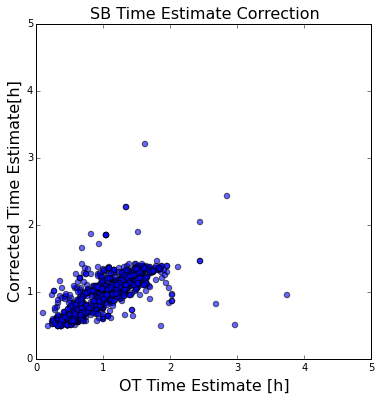

In [25]:
# sns.set_style('darkgrid')
# color = sns.color_palette()[1]

fig = plt.figure(figsize=[6,6])
ax = plt.subplot()
ax.scatter(remaining_all.SB_ETC_exec, remaining_all.SB_ETC2_exec, alpha=0.6, s=30)
ax.set_xlim(0,5)
ax.set_ylim(0,5)
ax.set_title('SB Time Estimate Correction', fontsize=16)
ax.set_xlabel('OT Time Estimate [h]', fontsize=16)
ax.set_ylabel('Corrected Time Estimate[h]', fontsize=16)


In [26]:
# remaining.groupby(['CODE', 'Problem'])[['sbName']].count().unstack().head()

In [27]:
# run small simm
#res3, res4 = ct.runsim(date_df, remaining, ct.alma1)
#d = pd.DataFrame(np.array(res4), columns=['time', 'lst', 'day', 'bands', 'array', 'SB_UID', 'SBremExec', 'RA', 'Grade'])
#d.to_excel('/home/itoledo/Downloads/sim.xls')
#date_df.to_csv('/home/itoledo/Downloads/d.csv')

In [28]:
remaining[remaining.isPolarization == True].query('C34_1 == 1 or C34_2 == 1').query('PRJ_LETTER_GRADE != "C"')[['CODE', 'PRJ_LETTER_GRADE', 'SB_UID', 'sbName', 'band', 'RA', 'execount', 'observed', 'C34_1', 'C34_2','bestconf','rise', 'set', 'Problem', 'days', 'weekend']].sort(['Problem', 'RA'])

,CODE,PRJ_LETTER_GRADE,SB_UID,sbName,band,RA,execount,observed,C34_1,C34_2,bestconf,rise,set,Problem,days,weekend
SB_UID,,,,,,,,,,,,,,,,
uid://A001/X13f/Xe8,2013.1.01282.S,B,uid://A001/X13f/Xe8,Centauru_a_07_TE,ALMA_RB_07,13.42434,2,0,0,1,C34-2,7.861732,17.018301,High SBEL,28,4
uid://A001/X121/X48f,2013.1.00764.S,A,uid://A001/X121/X48f,Sgr_A_st_a_06_TE,ALMA_RB_06,17.76112,5,2,0,1,C34-2,12.501554,21.053875,High SBEL,75,15
uid://A001/X121/X490,2013.1.00764.S,A,uid://A001/X121/X490,Sgr_A_st_b_06_TE,ALMA_RB_06,17.76112,2,0,0,1,C34-2,12.501554,21.053875,High SBEL,75,15
uid://A001/X121/X491,2013.1.00764.S,A,uid://A001/X121/X491,Sgr_A_st_c_06_TE,ALMA_RB_06,17.76112,2,0,0,1,C34-2,12.501554,21.053875,High SBEL,75,15
uid://A001/X146/X96,2013.1.01274.S,B,uid://A001/X146/X96,NAME_L32_a_07_TE,ALMA_RB_07,18.28319,3,0,1,1,C34-1,13.270065,21.326758,High SBEL,62,6
uid://A001/X121/X398,2013.1.01380.S,B,uid://A001/X121/X398,B335_a_06_TE,ALMA_RB_06,19.61692,2,0,0,1,C34-2,15.331073,21.927900,High SBEL,14,4
uid://A001/X13a/X9d,2013.1.00254.S,B,uid://A001/X13a/X9d,iras4a_a_07_TC,ALMA_RB_07,3.486243,3,0,0,1,C34-2,0.421297,4.582202,Null SBEL,0,0
uid://A001/X144/X105,2013.1.00231.S,B,uid://A001/X144/X105,MMS1_a_07_TE,ALMA_RB_07,5.588342,3,0,0,1,C34-2,0.905857,8.295511,Null SBEL,0,0
uid://A001/X144/X106,2013.1.00231.S,B,uid://A001/X144/X106,MMS3_a_07_TE,ALMA_RB_07,5.588606,3,0,0,1,C34-2,0.905857,8.296037,Null SBEL,0,0


In [29]:
two12m = remaining.query('C34_1 == 1 or C34_2 == 1').query('PRJ_LETTER_GRADE != "C"').query('two_12m == True')[['CODE', 'SG_ID', 'SB_UID', 'sbName', 'band', 'RA', 'execount', 'observed', 'C34_1', 'C34_2','bestconf','rise', 'set', 'Problem', 'Prj. Problem', 'days', 'weekend']].sort(['Prj. Problem', 'Problem', 'RA'])


In [30]:
sg_two12m = two12m.SG_ID.values

In [31]:
two12m.sort('CODE')

,CODE,SG_ID,SB_UID,sbName,band,RA,execount,observed,C34_1,C34_2,bestconf,rise,set,Problem,Prj. Problem,days,weekend
SB_UID,,,,,,,,,,,,,,,,,
uid://A001/X122/X4d4,2013.1.00055.S,uid://A001/X10b/X5b_2,uid://A001/X122/X4d4,NGC1068_a_09_TC,ALMA_RB_09,2.711325,1,0,0,1,C34-2,22.176772,5.271402,Null SBEL,Null PCL,0,0
uid://A001/X12f/X209,2013.1.00073.S,uid://A001/X10b/Xa7_1,uid://A001/X12f/X209,M87_a_06_TC,ALMA_RB_06,12.51373,1,0,0,1,C34-2,8.405801,14.648082,Null SBEL,Null PCL,0,0
uid://A001/X13a/X9d,2013.1.00254.S,uid://A001/X10e/Xe9_1,uid://A001/X13a/X9d,iras4a_a_07_TC,ALMA_RB_07,3.486243,3,0,0,1,C34-2,0.421297,4.582202,Null SBEL,Null PCL,0,0
uid://A001/X136/X30,2013.1.00367.S,uid://A001/X10f/X26d_1,uid://A001/X136/X30,orion_kl_b_09_TC,ALMA_RB_09,5.587267,1,0,0,1,C34-2,0.894480,8.304664,Null SBEL,Null PCL,0,0
uid://A001/X121/X2b5,2013.1.00694.S,uid://A001/X10e/X6da_1,uid://A001/X121/X2b5,IM_Lup_a_07_TC,ALMA_RB_07,15.93588,1,0,1,0,C34-1,10.484795,19.421881,Null SBEL,Null PCL,0,0
uid://A001/X121/X13b,2013.1.00813.S,uid://A001/X10e/X8d7_2,uid://A001/X121/X13b,Arp_220_a_08_TC,ALMA_RB_08,15.58256,1,0,0,1,C34-2,11.998045,17.190016,Null SBEL,Null PCL,0,0
uid://A001/X13a/X145,2013.1.01086.S,uid://A001/X112/X23_2,uid://A001/X13a/X145,L1527_IR_a_06_TC,ALMA_RB_06,4.664975,1,0,0,1,C34-2,1.239219,6.121547,Low SBEL,Null PCL,4,4
uid://A001/X13a/X143,2013.1.01086.S,uid://A001/X112/X23_1,uid://A001/X13a/X143,L1527_IR_a_07_TC,ALMA_RB_07,4.664975,1,0,0,1,C34-2,1.239219,6.121547,Null SBEL,Null PCL,0,0
uid://A001/X12a/X220,2013.1.01329.S,uid://A001/X113/X4ce_1,uid://A001/X12a/X220,n613_a_07_TC,ALMA_RB_07,1.571732,1,0,0,1,C34-2,20.299725,4.866453,Null SBEL,Null PCL,0,0


In [32]:
summary.query('SG_ID in @sg_two12m')[summary.query('SG_ID in @sg_two12m').sbName.str.endswith('_TE')].query('observed > 0 and SB_STATE != "FullyObserved"')

,OBSPROJECT_UID,CODE,PRJ_LETTER_GRADE,PRJ_STATUS,isCycle2,SB_UID,SG_ID,OUS_ID,sbName,sbStatusXml,repfreq,band,array,RA,DEC,minAR_ot,maxAR_ot,execount,isPolarization,maxPWVC,array12mType,AR,LAS,minArrayAR,maxArrayAR,AR100GHz,LAS100GHz,minArrayAR100GHz,maxArrayAR100GHz,C34_1,C34_2,C34_3,C34_4,C34_5,C34_6,C34_7,allowed12m,corr_allowed12m,phase,SB_ETC_exec,observed,SB_ETC_total,SB_ETC_remain,LST,bestconf,SB_STATE,intTime,SB_ETC2_exec,proj_comp_per
2190,uid://A001/X113/X4ce,2013.1.01329.S,B,InProgress,True,uid://A001/X12a/X21f,uid://A001/X113/X4ce_1,X3990336,n613_a_07_TE,Ready,354.9767,ALMA_RB_07,TWELVE-M,23.57598,-29.41849,0.1911368,0.2336116,2,False,0.6,Ext,0.25,14,0.175,0.275,0.876137,49.063675,0.613296,0.963751,0,0,0,0,1,0,0,1,1,II,0.244875,1,0.48975,0.244875,1,C34-5,Ready,0.108118,0.589827,0.5


In [33]:
remaining.query('SG_ID in @sg_two12m')[remaining.query('SG_ID in @sg_two12m').sbName.str.endswith('_TE')].query('observed == 0 and days == 0')

,OBSPROJECT_UID,CODE,PRJ_LETTER_GRADE,PRJ_STATUS,isCycle2,SB_UID,SG_ID,OUS_ID,sbName,sbStatusXml,repfreq,band,array,RA,DEC,minAR_ot,maxAR_ot,execount,isPolarization,maxPWVC,array12mType,AR,LAS,minArrayAR,maxArrayAR,AR100GHz,LAS100GHz,minArrayAR100GHz,maxArrayAR100GHz,C34_1,C34_2,C34_3,C34_4,C34_5,C34_6,C34_7,allowed12m,corr_allowed12m,phase,SB_ETC_exec,observed,SB_ETC_total,SB_ETC_remain,LST,bestconf,SB_STATE,intTime,SB_ETC2_exec,proj_comp_per,PI,EXEC,ACCOUNT_ID,LASTNAME,FIRSTNAME,EMAIL,two_12m,rise,set,up,available_hours,days,days_crit,weekend,SBremExec,SBtimeNeedComp,stale,proj_started,Problem,Prj. Problem,Cycle,Null SBEL Description,Representative LST,SB_ETC2_total,SB_ETC2_remain
SB_UID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
uid://A001/X136/X2f,uid://A001/X10f/X26d,2013.1.00367.S,B,InProgress,True,uid://A001/X136/X2f,uid://A001/X10f/X26d_1,X486369979,orion_kl_b_09_TE,NewPhase2,664.9778,ALMA_RB_09,TWELVE-M,5.587267,-5.37264,0.1499183,0.1832335,1,False,0.4,Ext,0.18,5,0.126,0.198,1.161902,32.275061,0.813332,1.278092,0,0,0,1,0,0,0,1,1,II,0.698633,0,0.698633,0.698633,5,C34-4,Ready,0.110833,0.592806,0,ptpho,NA,ptpho,Ho,Paul,paul@asiaa.sinica.edu.tw,True,0.89448,8.304664,7.410184,0,0,0,0,1,0.592806,SB Ready,Prj. Ready,Null SBEL,Null PCL,Cycle 2,Daytime High Frequency,6,0.592806,0.592806


In [43]:
remaining.query('(C34_1 == 1 or C34_2 == 1) and two_12m == False and isPolarization == False').query('PRJ_LETTER_GRADE != "C"').query('observed > 0')[['CODE', 'SB_UID', 'execount', 'observed', 'sbName', 'band', 'RA', 'C34_1', 'C34_2','bestconf','rise', 'set', 'Problem', 'Prj. Problem', 'days', 'weekend']].sort(['Problem', 'band', 'RA'])

,CODE,SB_UID,execount,observed,sbName,band,RA,C34_1,C34_2,bestconf,rise,set,Problem,Prj. Problem,days,weekend
SB_UID,,,,,,,,,,,,,,,,
uid://A001/X146/X4a,2013.1.01119.S,uid://A001/X146/X4a,2,1,Abell_27_a_06_TE,ALMA_RB_06,0.2386048,0,1,C34-2,18.946992,3.555199,High SBEL,High PCL,70,20
uid://A001/X145/X36e,2013.1.01241.S,uid://A001/X145/X36e,6,3,A383_a_06_TE,ALMA_RB_06,2.800907,0,1,C34-2,22.162089,5.464760,High SBEL,High PCL,50,20
uid://A001/X146/X4c,2013.1.01119.S,uid://A001/X146/X4c,2,1,AS1063_a_06_TE,ALMA_RB_06,22.81256,0,1,C34-2,17.219609,2.434364,High SBEL,High PCL,70,20
uid://A002/X5d7935/X3c4,2012.1.00979.S,uid://A002/X5d7935/X3c4,2,1,Multi-source_cont,ALMA_RB_07,2.301218,0,1,C34-2,21.612148,5.015191,High SBEL,Null PCL,42,4
uid://A001/X146/X2e,2013.1.00139.S,uid://A001/X146/X2e,4,2,CDFS_126_a_07_TE,ALMA_RB_07,3.538347,0,1,C34-2,22.300888,6.796336,High SBEL,High PCL,42,2
uid://A001/X122/X3a1,2013.1.00745.S,uid://A001/X122/X3a1,2,1,BR1202-0_a_07_TE,ALMA_RB_07,12.08974,1,1,C34-1,7.331742,14.874601,High SBEL,High PCL,28,0
uid://A002/X5a9a13/X148,2012.1.00196.S,uid://A002/X5a9a13/X148,2,1,L694-2_372_12m_C32-2,ALMA_RB_07,19.68458,0,1,C34-2,15.523902,21.869785,High SBEL,High PCL,14,0
uid://A001/X12d/Xe4,2013.1.01010.S,uid://A001/X12d/Xe4,3,1,SDF-LBG-_a_08_TE,ALMA_RB_08,13.39604,0,1,C34-2,10.055819,14.760962,High SBEL,High PCL,28,0
uid://A001/X121/X4f9,2013.1.01052.S,uid://A001/X121/X4f9,3,2,ID3_high_a_08_TE,ALMA_RB_08,22.81273,1,1,C34-1,17.219565,2.434741,High SBEL,High PCL,70,2


In [38]:
tc_sg = datas.sciencegoals.query('isTimeConstrained == True').SG_ID.unique()

In [39]:
remaining.query('SG_ID in @tc_sg and (C34_1 == 1 or C34_2 == 1 or C34_3 == 1) and PRJ_LETTER_GRADE != "C"')

,OBSPROJECT_UID,CODE,PRJ_LETTER_GRADE,PRJ_STATUS,isCycle2,SB_UID,SG_ID,OUS_ID,sbName,sbStatusXml,repfreq,band,array,RA,DEC,minAR_ot,maxAR_ot,execount,isPolarization,maxPWVC,array12mType,AR,LAS,minArrayAR,maxArrayAR,AR100GHz,LAS100GHz,minArrayAR100GHz,maxArrayAR100GHz,C34_1,C34_2,C34_3,C34_4,C34_5,C34_6,C34_7,allowed12m,corr_allowed12m,phase,SB_ETC_exec,observed,SB_ETC_total,SB_ETC_remain,LST,bestconf,SB_STATE,intTime,SB_ETC2_exec,proj_comp_per,PI,EXEC,ACCOUNT_ID,LASTNAME,FIRSTNAME,EMAIL,two_12m,rise,set,up,available_hours,days,days_crit,weekend,SBremExec,SBtimeNeedComp,stale,proj_started,Problem,Prj. Problem,Cycle,Null SBEL Description,Representative LST,SB_ETC2_total,SB_ETC2_remain
SB_UID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
uid://A002/X5a9a13/X6f5,uid://A001/Xa0/Xd78,2012.1.00584.T,B,InProgress,False,uid://A002/X5a9a13/X6f5,uid://A001/Xa0/Xd78_2,X1743104219,Supernova_ToO_upon_a_discovery-band6,Ready,259,ALMA_RB_06,TWELVE-M,0,0,0,0,1,False,1.2,Ext,0.7,0,0.197026,0.77,1.794339,0,0.505045,1.973773,0,0,1,1,1,1,0,4,4,II,1.154620,0,1.154620,1.154620,0,C34-3,Ready,0.640667,1.174139,0.000000,kmaeda,EA,kmaeda,Maeda,Keiichi,keiichi.maeda@kusastro.kyoto-u.ac.jp,False,19.466637,2.559088,7.092451,414.932629,68,2,20,1,1.174139,SB Ready,Prj. Ready,High SBEL,High PCL,Cycle 1,,0,1.174139,1.174139
uid://A002/X5a9a13/X6f6,uid://A001/Xa0/Xd78,2012.1.00584.T,B,InProgress,False,uid://A002/X5a9a13/X6f6,uid://A001/Xa0/Xd78_3,X72255317,Supernova_ToO_upon_a_discovery-band7,Ready,350,ALMA_RB_07,TWELVE-M,0,0,0,0,1,False,0.6,Ext,0.7,0,0.145799,0.77,2.424782,0,0.505045,2.667260,0,1,1,1,1,1,0,5,5,II,1.407652,0,1.407652,1.407652,0,C34-2,Ready,0.436816,0.950474,0.000000,kmaeda,EA,kmaeda,Maeda,Keiichi,keiichi.maeda@kusastro.kyoto-u.ac.jp,False,19.466637,2.559088,7.092451,351.760068,56,14,11,1,0.950474,SB Ready,Prj. Ready,High SBEL,High PCL,Cycle 1,,0,0.950474,0.950474
uid://A001/X121/X48f,uid://A001/X10e/X80a,2013.1.00764.S,A,InProgress,True,uid://A001/X121/X48f,uid://A001/X10e/X80a_1,X1548884411,Sgr_A_st_a_06_TE,Ready,224,ALMA_RB_06,TWELVE-M,17.76112,-29.00782,0.8183517,1.000208,5,True,1.2,Ext,1.0,0,0.227812,1.10,2.212148,0,0.503953,2.433363,0,1,1,1,1,1,0,5,5,II,0.888889,2,4.444444,2.666667,17,C34-2,Ready,0.500000,1.019800,0.222222,gbower,NA,gbower,Bower,Geoffrey,gbower@asiaa.sinica.edu.tw,False,12.501554,21.053875,8.552320,549.814871,75,7,15,3,3.059400,SB Ready,Prj. Stale,High SBEL,High PCL,Cycle 2,,18,5.099000,3.059400
uid://A001/X121/X490,uid://A001/X10e/X80a,2013.1.00764.S,A,InProgress,True,uid://A001/X121/X490,uid://A001/X10e/X80a_1,X1548884411,Sgr_A_st_b_06_TE,Ready,224,ALMA_RB_06,TWELVE-M,17.76112,-29.00782,0.8183517,1.000208,2,True,1.2,Ext,1.0,0,0.227812,1.10,2.212148,0,0.503953,2.433363,0,1,1,1,1,1,0,5,5,II,0.888889,0,1.777778,1.777778,17,C34-2,Ready,0.500000,1.019800,0.222222,gbower,NA,gbower,Bower,Geoffrey,gbower@asiaa.sinica.edu.tw,False,12.501554,21.053875,8.552320,549.814871,75,7,15,2,2.039600,SB Ready,Prj. Stale,High SBEL,High PCL,Cycle 2,,18,2.039600,2.039600
uid://A001/X121/X491,uid://A001/X10e/X80a,2013.1.00764.S,A,InProgress,True,uid://A001/X121/X491,uid://A001/X10e/X80a_1,X1548884411,Sgr_A_st_c_06_TE,Ready,224,ALMA_RB_06,TWELVE-M,17.76112,-29.00782,0.8183517,1.000208,2,True,1.2,Ext,1.0,0,0.227812,1.10,2.212148,0,0.503953,2.433363,0,1,1,1,1,1,0,5,5,II,0.888889,0,1.777778,1.777778,17,C34-2,Ready,0.500000,1.019800,0.222222,gbower,NA,gbower,Bower,Geoffrey,gbower@asiaa.sinica.edu.tw,False,12.501554,21.053875,8.552320,549.814871,75,7,15,2,2.039600,SB Ready,Prj. Stale,High SBEL,High PCL,Cycle 2,,18,2.039600,2.039600


In [40]:
summary.query('CODE == "2013.1.00735.S"')

,OBSPROJECT_UID,CODE,PRJ_LETTER_GRADE,PRJ_STATUS,isCycle2,SB_UID,SG_ID,OUS_ID,sbName,sbStatusXml,repfreq,band,array,RA,DEC,minAR_ot,maxAR_ot,execount,isPolarization,maxPWVC,array12mType,AR,LAS,minArrayAR,maxArrayAR,AR100GHz,LAS100GHz,minArrayAR100GHz,maxArrayAR100GHz,C34_1,C34_2,C34_3,C34_4,C34_5,C34_6,C34_7,allowed12m,corr_allowed12m,phase,SB_ETC_exec,observed,SB_ETC_total,SB_ETC_remain,LST,bestconf,SB_STATE,intTime,SB_ETC2_exec,proj_comp_per
2021,uid://A001/X10f/X703,2013.1.00735.S,B,InProgress,True,uid://A001/X13a/X17d,uid://A001/X10f/X703_1,X531071697,ngc_253_a_07_TE,Waiting,353.5051,ALMA_RB_07,TWELVE-M,11.8879,-25.28836,0.1443032,0.1763706,2,False,0.6,Ext,0.2,5,0.140000,0.22000,0.699517,17.487922,0.489662,0.769469,0,0,0,0,1,1,0,2,2,II,1.740747,0,3.481494,3.481494,0,C34-5,Ready,0.77,1.316044,0.333333
2022,uid://A001/X10f/X703,2013.1.00735.S,B,InProgress,True,uid://A001/X13a/X17e,uid://A001/X10f/X703_1,X531071697,ngc_253_a_07_TC,Waiting,353.5051,ALMA_RB_07,TWELVE-M,11.8879,-25.28836,0.35564,0.4346712,1,False,0.6,Comp,0.2,5,0.499758,0.66139,0.699517,17.487922,1.747946,2.313268,0,1,0,0,0,0,0,1,1,II,1.740747,1,1.740747,0.000000,0,C34-2,Suspended,0.77,1.316044,0.333333


In [45]:
remaining.query('C34_1 == 1 or C34_2 == 1').query("C34_3 == 0").query('PRJ_LETTER_GRADE != "C" and observed < execount')

,OBSPROJECT_UID,CODE,PRJ_LETTER_GRADE,PRJ_STATUS,isCycle2,SB_UID,SG_ID,OUS_ID,sbName,sbStatusXml,repfreq,band,array,RA,DEC,minAR_ot,maxAR_ot,execount,isPolarization,maxPWVC,array12mType,AR,LAS,minArrayAR,maxArrayAR,AR100GHz,LAS100GHz,minArrayAR100GHz,maxArrayAR100GHz,C34_1,C34_2,C34_3,C34_4,C34_5,C34_6,C34_7,allowed12m,corr_allowed12m,phase,SB_ETC_exec,observed,SB_ETC_total,SB_ETC_remain,LST,bestconf,SB_STATE,intTime,SB_ETC2_exec,proj_comp_per,PI,EXEC,ACCOUNT_ID,LASTNAME,FIRSTNAME,EMAIL,two_12m,rise,set,up,available_hours,days,days_crit,weekend,SBremExec,SBtimeNeedComp,stale,proj_started,Problem,Prj. Problem,Cycle,Null SBEL Description,Representative LST,SB_ETC2_total,SB_ETC2_remain
SB_UID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
uid://A002/X684eb5/X32,uid://A001/Xa0/X2d6,2012.1.00178.S,B,InProgress,False,uid://A002/X684eb5/X32,uid://A001/Xa0/X2d6_2,X1528090,L1689N_b_07_12,Suspended,309.9058,ALMA_RB_07,TWELVE-M,16.54144,-24.48239,0,0,3,False,0.9,Ext,2.000,10.00,1.041297,2.200000,6.133535,30.667675,3.193414,6.746889,1,0,0,0,0,0,0,1,1,II,0.439355,1,1.318065,0.878710,16,C34-1,Suspended,0.450000,0.964940,0.600000,dcl,NA,dcl,Lis,Dariusz,dcl@caltech.edu,False,11.380321,19.734411,8.354090,0,0,0,0,2,1.929880,SB Ready,Prj. Stale,Null SBEL,Null PCL,Cycle 1,Daytime High Frequency,17,2.894820,1.929880
uid://A002/X628157/X24,uid://A001/Xa0/X7cb,2012.1.00368.S,B,InProgress,False,uid://A002/X628157/X24,uid://A001/Xa0/X7cb_1,X351580590,Serpens__a_07_12,Ready,354.4972,ALMA_RB_07,TWELVE-M,18.49944,1.229167,0,0,1,False,0.6,Ext,1.700,90.00,0.910314,1.870000,5.744188,304.104056,3.075892,6.318606,1,0,0,0,0,0,0,1,1,II,0.497759,0,0.497759,0.497759,18,C34-1,Ready,0.440833,0.954882,0.500000,lgm,NA,lgm,Mundy,Lee,lgm@astro.umd.edu,False,14.002186,21.023142,7.020957,0,0,0,0,1,0.954882,SB Ready,Prj. Stale,Null SBEL,Null PCL,Cycle 1,Daytime High Frequency,18,0.954882,0.954882
uid://A002/X628157/X3b,uid://A001/Xa0/X87b,2012.1.00395.S,B,InProgress,False,uid://A002/X628157/X3b,uid://A001/Xa0/X87b_3,X508761358,orion-IRc2_709GHz_12m_C32-2,Ready,708.8557,ALMA_RB_09,TWELVE-M,5.587361,-5.375,0,0,2,False,0.4,Ext,0.500,3.00,0.350000,0.550000,3.440488,20.642930,2.408342,3.784537,1,0,0,0,0,0,0,1,1,II,1.096719,0,2.193438,2.193438,5,C34-1,Ready,0.420000,0.932024,0.142857,nmarcelino,NA,nmarcelino,Marcelino,Nuria,marcelino@ira.inaf.it,False,0.894509,8.304824,7.410315,0,0,0,0,2,1.864048,SB Ready,Prj. Stale,Null SBEL,Null PCL,Cycle 1,C34-1/2 High Frequency,6,1.864048,1.864048
uid://A002/X5d7935/X8,uid://A001/Xa0/X955,2012.1.00426.S,B,InProgress,False,uid://A002/X5d7935/X8,uid://A001/Xa0/X955_2,X774230720,J0302_607_12m_C32-123456,Ready,606.883,ALMA_RB_09,TWELVE-M,3.041019,0.114444,0,0,1,False,0.4,Ext,1.000,1.00,0.531740,1.100000,5.805229,5.805229,3.086872,6.385752,1,0,0,0,0,0,0,1,1,II,1.426833,0,1.426833,1.426833,3,C34-1,Ready,0.466667,0.983227,0.714286,shaileyd,NA,shaileyd,Hailey-Dunsheath,Steven,haileyds@caltech.edu,False,22.510220,5.597359,7.087139,0,0,0,0,1,0.983227,SB Ready,Prj. Stale,Null SBEL,Null PCL,Cycle 1,C34-1/2 High Frequency,3,0.983227,0.983227
uid://A002/X684eb5/X18a,uid://A001/Xa0/X10df,2012.1.00707.S,B,InProgress,False,uid://A002/X684eb5/X18a,uid://A001/Xa0/X10df_2,X94955206,Multisource_b9_Oph_12m,Ready,691.4731,ALMA_RB_09,TWELVE-M,16.44067,-24.40833,0,0,1,False,0.4,Ext,0.540,3.50,0.375695,0.594000,3.695095,23.949692,2.570796,4.064605,1,0,0,0,0,0,0,1,1,II,1.211710,0,1.211710,1.211710,16,C34-1,Ready,0.608261,1.138584,0.250000,demerese,CL,demerese,Salter,Demerese,demerese@astro.umd.edu,False,11.281136,19.632011,8.350875,0,0,0,0,1,1.138584,SB Ready,Prj. Stale,Null SBEL,Null PCL,Cycle 1,C34-1/2 High Frequency,16,1.138584,1.138584
uid://A002/X684eb5/X18c,uid://A001/Xa0/X10df,2012.1.00707.S,B,InProgress,False,uid://A002/X684eb5/X18c,uid://A001/Xa0/X10df_4,X1865275061,Multi-source_Taurus_B9_12m,Ready,691.4731,ALMA_RB_09,TWELVE-M,4.659775,25.69575,0,0,1,False,0.4,Ext,0.540,3.50,0.375695,0.594000,3.068730,19.889918,1.921512,3.713164,0,